### Resultado final

El resultado final será un modelo de aprendizaje profundo entrenado, capaz de clasificar diversas imágenes de frutas en sus respectivas categorías. También visualizará la precisión y las predicciones del modelo en imágenes de prueba de muestra.

### Objetivos de aprendizaje
Al finalizar el proyecto, podrás:
- Configurar y organizar un conjunto complejo de datos de imágenes de frutas.
- Utilizar el aprendizaje por transferencia con el modelo VGG16.
- Ajustar un modelo preentrenado para tu conjunto de datos.
- Evaluar e interpretar el rendimiento del modelo con datos no analizados.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
#Librerías necesarias para poder comenzar el entrenamiento.
!pip install tensorflow==2.16.2
!pip install matplotlib==3.9.2
!pip install numpy==1.26.4
!pip install scipy==1.14.1
!pip install scikit-learn==1.5.2



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorfl

### Preparación de datos 


Estructura del directorio

Asegúrese de que su conjunto de datos esté organizado de la siguiente manera:


dataset/
├── train/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
├── val/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
└── test/
    ├── Class1/
    ├── Class2/
    ├── Class3/
    └── (other classes...)


Cada subdirectorio bajo train y val debe contener imágenes de la respectiva categoría de fruta.


## Descargamos los archivos de entrada

La descarga del conjunto de datos puede tardar hasta 30 minutos.

In [4]:
import os
import subprocess
import zipfile


url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    print("descargar el dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  
    print("descarga completa.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    print("Extrayendo el conjunto de datos en fragmentos...")
    os.makedirs(extract_to, exist_ok=True)  
    
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  #listamos todos los archivos del conjunto de datos
        total_files = len(files)
        
        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extraemos
            print(f"extraemos {min(i+batch_size, total_files)} de {total_files} archivos...")
    
    print(f"Conjunto de datos extraído exitosamente a '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # descargamos si no lo estan
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")
    
    # extraemos
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")
    
    # Limpiamos 
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Limpiamos zip archivo: {local_zip}")


descargar el dataset...
descarga completa.
Extrayendo el conjunto de datos en fragmentos...
extraemos 2000 de 12481 archivos...
extraemos 4000 de 12481 archivos...
extraemos 6000 de 12481 archivos...
extraemos 8000 de 12481 archivos...
extraemos 10000 de 12481 archivos...
extraemos 12000 de 12481 archivos...
extraemos 12481 de 12481 archivos...
Conjunto de datos extraído exitosamente a 'fruits-360-original-size'.
Limpiamos zip archivo: fruits-360-original-size.zip


<h5>Note: If you see warnings related to GPU (e.g., CUDA or cuDNN), it means the system is running on the CPU. Training may take longer.</h5>



## Importar las bibliotecas necesarias y establecer las rutas de los conjuntos de datos

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Establecemos las rutas de conjuntos de datos
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'


2025-05-28 12:22:56.962589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-28 12:22:56.995329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-28 12:22:56.995415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Explicación de la biblioteca:
- `ImageDataGenerator:` Para cargar imágenes y aplicar aumento de datos.
- `VGG16:` Modelo preentrenado para el aprendizaje por transferencia.
- `Sequential:` Para construir un modelo secuencial.
- `Dense, Flatten, Dropout, BatchNormalization:` Capas para personalizar la arquitectura del modelo.
- `ReduceLROnPlateau, EarlyStopping:` Devoluciones de llamada para optimizar el entrenamiento.


## Configurar generadores de datos para entrenamiento, validación y pruebas con aumento

**Explicación:** Los generadores de datos cargan imágenes de directorios, las reescalan y aplican mejoras al conjunto de entrenamiento para facilitar la generalización del modelo. Los conjuntos de validación y prueba solo se reescalan (no se aplican mejoras).


In [6]:
# Generadores de datos de imagenes
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Cargar imagenes desde directorios
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


### Explicación:
- `train_datagen:` Aplica reescalado y aumento (p. ej., rotación, zoom) para que el modelo sea más robusto.
- `val_datagen y test_datagen:` Reescalan las imágenes solo para validación/pruebas.
- `flow_from_directory:` Carga imágenes de carpetas específicas en lotes para entrenamiento/validación/pruebas.

## Definir la arquitectura del modelo basado en VGG16 con capas personalizadas


**Explicación:** Esta tarea implica cargar el modelo VGG16 previamente entrenado (excluyendo las capas superiores) y agregar capas personalizadas para adaptarlo a la tarea de clasificación de frutas.


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Explicación:
- `base_model`: Carga VGG16, excluyendo sus capas densas (`include_top=False`).
- `for coat in base_model.layers`: Congela las capas de VGG16 para conservar los pesos preentrenados.
- Capas personalizadas: Aplana la salida y luego agrega capas densas con regularización (Dropout) y normalización (BatchNormalization) para mejorar el aprendizaje.

## Compilar el modelo con la pérdida y el optimizador adecuados

**Explicación:** Compila el modelo para especificar la función de pérdida, el optimizador y la métrica de evaluación.


In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Explicación:
- `categorical_crossentropy:` Se utiliza porque se trata de una tarea de clasificación multiclase.
- `adam:` Optimizador de la tasa de aprendizaje adaptativo que ayuda a una convergencia más rápida.
- `metrics=['accuracy']:` Realiza un seguimiento de la precisión del modelo.


## Entrenar el modelo con parada temprana y programación de la tasa de aprendizaje

**Explicación:** Entrene el modelo, usando devoluciones de llamadas para monitorear la pérdida de validación y ajustar la tasa de aprendizaje o detenerse temprano para evitar el sobreajuste.

In [9]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Definimos el callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Habilitar precision mixta (si esta en la GPU)
set_global_policy('float32')

steps_per_epoch = 50 
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.1422 - loss: 3.1649 - val_accuracy: 0.2700 - val_loss: 2.5929 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 485ms/step - accuracy: 0.4579 - loss: 1.7775 - val_accuracy: 0.3625 - val_loss: 2.1676 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.5998 - loss: 1.3837 - val_accuracy: 0.5075 - val_loss: 1.8105 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 505ms/step - accuracy: 0.6646 - loss: 1.1200 - val_accuracy: 0.5675 - val_loss: 1.4516 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 502ms/step - accuracy: 0.6736 - loss: 1.0333 - val_accuracy: 0.6075 - val_loss: 1.2819 - learning_rate: 0.0010


### Explicación:
- `ReduceLROnPlateau`: Reduce la tasa de aprendizaje cuando la pérdida de validación se estabiliza, lo que permite una mejor optimización.
- `EarlyStopping`: Detiene el entrenamiento cuando la pérdida de validación deja de mejorar, lo que evita el sobreajuste.
- `model.fit`: Entrena el modelo en `train_generator` y lo evalúa en `val_generator` en cada época.

## Ajustar el modelo descongelando capas específicas en VGG16

**Explicación:** Realice ajustes finos descongelando algunas capas del modelo base VGG16 para permitir el aprendizaje de las características específicas de la fruta.

**Nota**: El ajuste fino puede requerir más tiempo en un equipo con CPU.

In [10]:
import tensorflow as tf  
from tensorflow.keras.optimizers import Adam

# Verificar el numero de capas en el modelo base
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Descongele las ultimas 5 capas para realizar ajustes finos
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Congele las capas BatchNorm para acelerar el ajuste fino
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Vuelva a compilar el modelo con un optimizador mas rapido
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Mayor tasa de aprendizaje para una convergencia mas rapida
    metrics=['accuracy']
)

#Continuar entrenando con menos pasos por epoca
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Pasos reducidos por epoca
    validation_steps=validation_steps,  # Pasos de validacion reducidos
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 685ms/step - accuracy: 0.7201 - loss: 0.8557 - val_accuracy: 0.7425 - val_loss: 0.8657 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 661ms/step - accuracy: 0.7632 - loss: 0.7070 - val_accuracy: 0.8500 - val_loss: 0.5573 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 655ms/step - accuracy: 0.8199 - loss: 0.5852 - val_accuracy: 0.7850 - val_loss: 0.6050 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.8328 - loss: 0.5277 - val_accuracy: 0.8300 - val_loss: 0.5295 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 823ms/step - accuracy: 0.8719 - loss: 0.4985 - val_accuracy: 0.8275 - val_loss: 0.5479 - learning_rate: 1.0000e-05


### Explicación:
- `for coat in base_model.layers[-5:]`: Descongela las últimas 5 capas para permitir un ajuste fino.
- Descongelar menos capas es más rápido y evita el sobreajuste en conjuntos de datos pequeños.
- `RMSprop(learning_rate=1e-5)`: Optimizador con una tasa de aprendizaje más baja para realizar un ajuste fino con cuidado sin cambios drásticos de peso.

## Evaluar el modelo en el conjunto de prueba y mostrar la precisión

**Explicación**: Evalúa el modelo final en datos de prueba no vistos para medir su generalización.


In [11]:
# Evaluar en el conjunto de pruebas
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.8680 - loss: 0.4526
Test Accuracy: 0.85


### Explicación:

- `model.evaluate(test_generator)`: Evalúa el modelo en el conjunto de pruebas e imprime la precisión, lo que proporciona una medida final del rendimiento del modelo.

## Visualizar el rendimiento del entrenamiento con precisión y curvas de pérdida

**Explicación**: Grafica la precisión y la pérdida de entrenamiento y validación para comprender el progreso de aprendizaje del modelo.


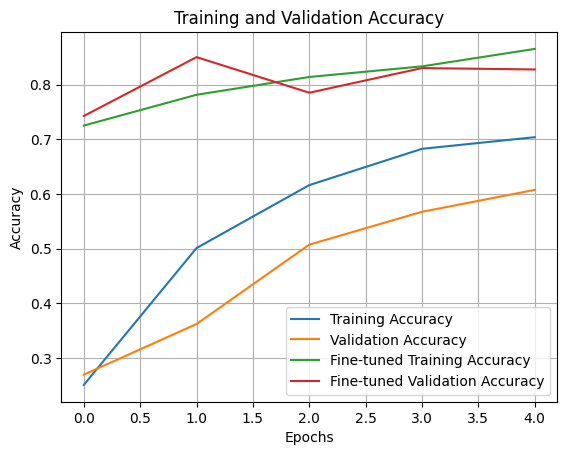

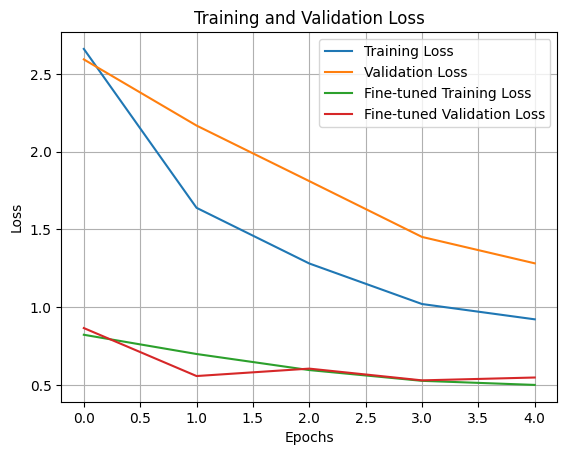

In [12]:
# Precisión del gráfico y curvas de pérdida
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

### Explicación:

- `plt.plot`: Representa gráficamente la precisión y la pérdida del entrenamiento y la validación a lo largo de épocas.

- La comparación visual muestra si el modelo presenta sobreajuste, subajuste o aprendizaje eficaz.

## Probar las predicciones del modelo en imágenes de muestra y visualizar los resultados

**Explicación:** Realiza predicciones en algunas imágenes de prueba y las muestra con la clase prevista del modelo.

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


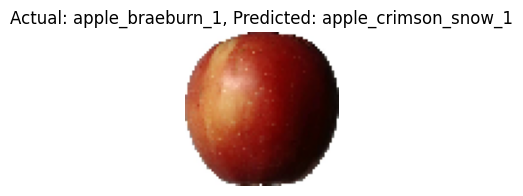

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


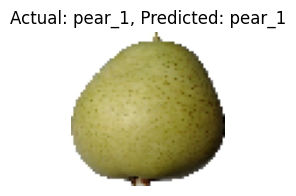

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


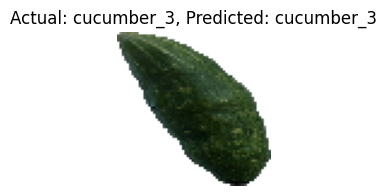

In [13]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Inicializar contadores para clases reales y previstas
actual_count = Counter()
predicted_count = Counter()

# Funcion para obtener el nombre de la clase a partir del indice previsto
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Predeterminado si no se encuentra el indice

# Define la funcion para la visualización
def visualize_prediction_with_actual(img_path, class_index_mapping):
   # Extrae la etiqueta verdadera dinamicamente de la estructura del directorio
    class_name = os.path.basename(os.path.dirname(img_path))  # Extraer el nombre de la carpeta (clase)
    
    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=(64, 64)) 
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predecir la clase
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Actualizar los controladores
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualiza la imagen con predicciones
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Recuperar la asignacion del indice de clase del generador de entrenamiento
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define una lista de rutas de imagenes sin etiquetas codificadas
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Ejecutar las predicciones y la visualizacion
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


### Conclusión

### Explicación:

- `visualize_prediction`: Carga una imagen, la preprocesa, predice su clase y la muestra.

- `model.predict(img_array)`: Utiliza el modelo entrenado para realizar predicciones sobre imágenes no vistas.

##### Si se produce una predicción incorrecta durante las pruebas, los siguientes factores podrían contribuir a la clasificación errónea:

Similitud de clases: Las clases de frutas visualmente similares (por ejemplo, tipos de manzana) pueden confundir al modelo.

Datos insuficientes: Los conjuntos de datos desequilibrados con menos muestras para ciertas clases pueden causar un subajuste.

Entrenamiento limitado: Ajustar menos capas podría no capturar suficientes características específicas de la clase.

Impacto del aumento de datos: Los aumentos agresivos pueden distorsionar las características clave, lo que reduce la precisión de imágenes específicas.

## Conclusión
Se implementó un modelo de clasificación de frutas mediante aprendizaje por transferencia con VGG16. Mediante el ajuste fino y el uso de aumento de datos, desarrolló un clasificador robusto capaz de reconocer diferentes frutas. Se demostró la eficiencia del aprendizaje por transferencia para lograr una alta precisión con datos de entrenamiento mínimos.